# IAM UBA Workshop 2019

## 4. Optimization

This section will show you how you can use the ability to modify parameters of a model to run an optimization that finds the optimal climate policy in DICE.

We will use the [BlackBoxOptim.jl](https://github.com/robertfeldt/BlackBoxOptim.jl) optimization package for the actual optimization algorithm, so we first load that package, and all the other packages we need for this exercise:

In [1]:
using BlackBoxOptim, MimiDICE2010, VegaLite, Mimi

It will again be helpful to have a base version of the model that we can compare with the optimized version of the model, so we create and run that base version first:

In [2]:
m_dice1 = MimiDICE2010.get_model()
run(m_dice1)

Then we create the instance of the model that we will use for the actual optimization:

In [3]:
m_opt = MimiDICE2010.get_model()

9-component Mimi.Model:
  grosseconomy::MimiDICE2010.grosseconomy
  emissions::MimiDICE2010.emissions
  co2cycle::MimiDICE2010.co2cycle
  radiativeforcing::MimiDICE2010.radiativeforcing
  climatedynamics::MimiDICE2010.climatedynamics
  sealevelrise::MimiDICE2010.sealevelrise
  damages::MimiDICE2010.damages
  neteconomy::MimiDICE2010.neteconomy
  welfare::MimiDICE2010.welfare


To interface with the solvers in BlackBoxOptim.jl, we need to define a function that the solver can call to evaluate our model for a given vector of values for the choice variables of our problem.

Here we define such a function and name it `eval_dice`. The argument to this function is the emissions control vector.

The first step in this function is to use `set_param!` to set the model instance's parameter `MIU` in component `emissions` to the values we received from the solver. We then run the model by calling the `run` function, and finally retrieve the value for total welfare, the quantity we aim to maximize, from the model. Note that BlackBoxOptim.jl will try to minimize the objective function, but we of course want to maximize welfare, so we actually return the negative of welfare from this function.

In [4]:
function eval_dice(x)
    set_param!(m_opt, :emissions, :MIU, x)
    run(m_opt)
    return -m_opt[:welfare, :UTILITY]
end

eval_dice (generic function with 1 method)

To run the actual optimization, we simply call the function `bboptimize` from BlackBoxOptim.jl, and pass it the function we just created, plus some configuration parameters. In particular, we bound our choice variables between 0 and 1 using `SearchRange`, and set the number of choice variables to 60, i.e. the number of time periods in our model, using `NumDimensions`.

In [5]:
res = bboptimize(eval_dice; SearchRange=(0., 1.0), NumDimensions=60, Method=:adaptive_de_rand_1_bin_radiuslimited, MaxSteps=20_000)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 251 evals, 161 steps, improv/step: 0.391 (last = 0.3913), fitness=-2258.614551187
1.00 secs, 599 evals, 485 steps, improv/step: 0.412 (last = 0.4228), fitness=-2259.285335323
1.51 secs, 995 evals, 877 steps, improv/step: 0.374 (last = 0.3265), fitness=-2260.700866225
2.01 secs, 1366 evals, 1248 steps, improv/step: 0.356 (last = 0.3127), fitness=-2261.388128571
2.51 secs, 1754 evals, 1636 steps, improv/step: 0.351 (last = 0.3376), fitness=-2261.724808986
3.01 secs, 2152 evals, 2034 steps, improv/step: 0.345 (last = 0.3166), fitness=-2262.354776871
3.51 secs, 2550 evals, 2432 steps, improv/step: 0.343 (last = 0.3367), fitness=-2262.355497164
4.01 secs, 2942 evals, 2824 steps, improv/step: 0.335 (last = 0.2806), fitness=-2262.493964831
4.51 secs, 3338 evals, 3220 steps, improv/ste

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (20000) reached", 20001, 1.569373542216e9, 26.11299991607666, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 942243,:NumDimensions => 60,:SearchRange => (0.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxSteps => 20000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 20119, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(-2263.503470908036, [0.0004717808885438818, 0.18504818394764463, 0.25435015822766927, 0.2981016764479898, 0.3609626293522561, 0.41190705610812717, 0.47363812396935445, 0.5293322390802659, 0.6136967317506739, 0.6747306010840

We can obtain the value of the emission control vector for the best policy that the solver found by calling the `best_candidate` function from the BlackBoxOptim package.

In [6]:
best_candidate(res)

60-element Array{Float64,1}:
 0.0004717808885438818
 0.18504818394764463  
 0.25435015822766927  
 0.2981016764479898   
 0.3609626293522561   
 0.41190705610812717  
 0.47363812396935445  
 0.5293322390802659   
 0.6136967317506739   
 0.6747306010840293   
 0.7402335756406964   
 0.8163763159361425   
 0.8805733016332484   
 ⋮                    
 0.8127220228985668   
 0.12400319300819601  
 0.4117576459473312   
 0.02246010591265987  
 0.12473993386461511  
 0.4725316260390361   
 0.5153519936815887   
 0.5371862102212026   
 0.5807951151097508   
 0.9250602576217978   
 0.6659435377345856   
 0.718772178512015    

Let's actually set the parameter for the emission control rate in our model instance to that best policy that the solver found by calling `set_param!` one more time. We can then rerun the model, and at this point our model has the values for all variables for the optimal policy.

In [7]:
set_param!(m_opt, :emissions, :MIU, best_candidate(res))
run(m_opt)

We can now plot the business as usual policy and compare it with the optimal policy our solver found:

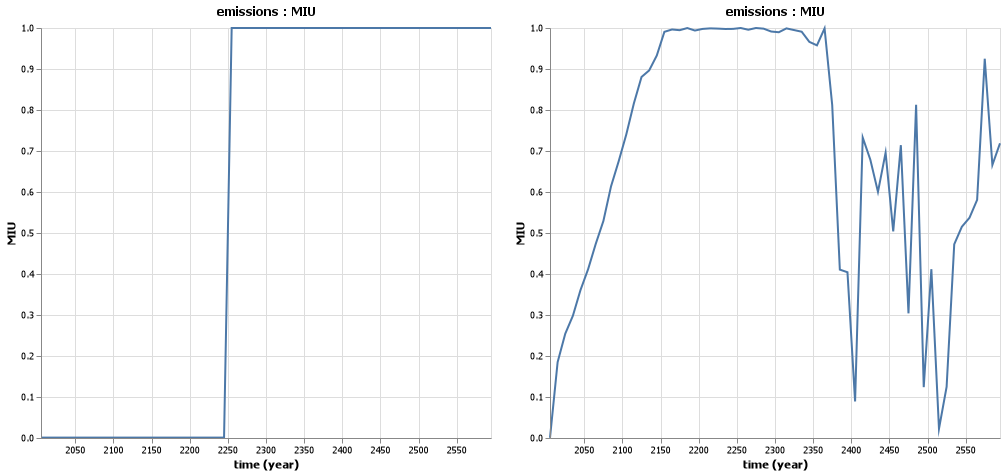

In [8]:
@vlplot(resolve={scale={y=:shared}}) + [Mimi.plot(m_dice1, :emissions, :MIU) Mimi.plot(m_opt, :emissions, :MIU)]

For the first half of the period, the solver found the typical optimal policy ramp that characterizes DICE. The second half of our solution once again suffers from the fact that we don't properly handle the backstop case in this simple example, as we saw in the third notebook on Modifying Parameters. It would probably be more sensible to only optimize the first half of the model time period, and then assume 100% mitigation rate for the second half, like we did in our previous example. We will not fix this issue in this example tutorial, because we our goal is only to highlight the technical aspects of running an optimization.

Looking at the temperature for our optimization, and ignoring the second half of the model time period, we can see a significant impact of our optimal policy on temperatures.

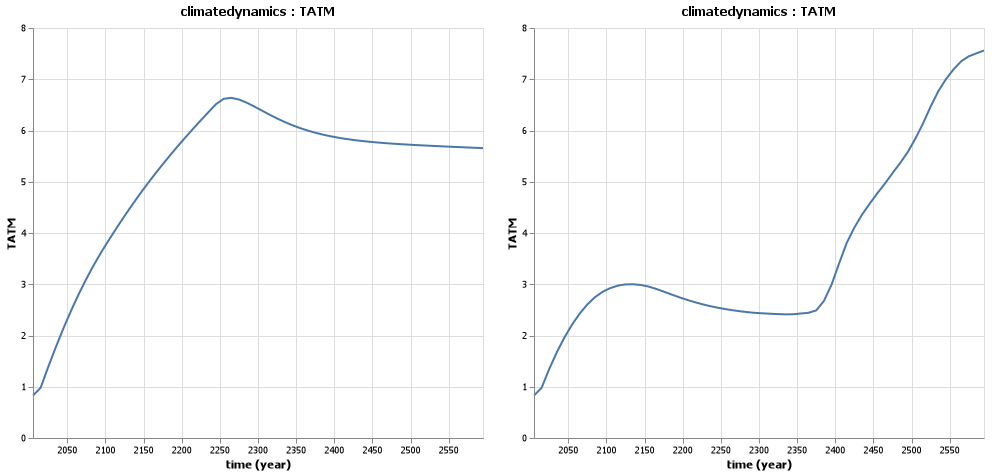

In [9]:
@vlplot(resolve={scale={y=:shared}}) + [Mimi.plot(m_dice1, :climatedynamics, :TATM) Mimi.plot(m_opt, :climatedynamics, :TATM)]